In [1]:
import json
import numpy as np
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from lmfit import Parameters, minimize, report_fit
import sys
import os

import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']


# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)


In [2]:
### NMR degradation data

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['lnkdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)

# linear fit to get curve
model = lmfit.models.LinearModel()
params = model.make_params()
deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])
#deg_result.plot(fig_kws={'figsize': (3, 3)})
#plt.show()

# get slope and intercept
slope = deg_result.params['slope'].value
intercept = deg_result.params['intercept'].value


In [3]:
def get_kdeg(temp, slope=slope, intercept=intercept):
    return np.exp(slope / (temp + 273.15) + intercept)

def fmod_model(x, log_kappa, log_kdeg, log_fmod_0):
    kappa = np.exp(log_kappa)
    kdeg = np.exp(log_kdeg)
    fmod_0 = np.exp(log_fmod_0)
    return 1 - np.exp(- (kappa) * (1 - np.exp(-kdeg * x))) + fmod_0

def free_fit(df, temp, global_kdeg = None):
    site_nt = df['site'].astype(str).values[0] + df['base'].values[0]
    x_data = df['reaction_time'] * df['treated']
    y_data = df['fmod_val']

    model = lmfit.Model(fmod_model)

    kdeg0 = get_kdeg(temp)
    kappa0 = -np.log(1 - y_data.max())
    fmod_00 = max(y_data.min(), 1e-6)  # Avoid log(0) errors
    
    params = model.make_params(
        log_kappa=np.log(kappa0), 
        log_kdeg=np.log(kdeg0), 
        log_fmod_0=np.log(fmod_00)
    )
    
    if global_kdeg is not None:
        # this value is log already
        params['log_kdeg'].set(value=global_kdeg, vary=False)

    # No constraints needed since we fit in log space
    result = model.fit(y_data, params, x=x_data)
    
    # # Remove outlier outside of 1.5σ and refit
    outlier = np.abs(result.residual) > 150 * np.std(result.residual)
    
    if sum(outlier) > 0:
        x_data = x_data[~outlier]
        y_data = y_data[~outlier]
    
        # Initial values = values from previous fit
        params = model.make_params(
            log_kappa=result.best_values['log_kappa'], 
            log_kdeg=result.best_values['log_kdeg'], 
            log_fmod_0=result.best_values['log_fmod_0']
        )
        
        result = model.fit(y_data, params, x=x_data)

    return result, site_nt, outlier

# Create parameters
def create_params(free_fit_results):
    fit_params = Parameters()

    log_kdeg_global = free_fit_results['log_kdeg'].mean()

    # iterrate rows of free_fit_results
    for i in range(len(free_fit_results)):
        row = free_fit_results.iloc[i]
        site = row['site'].astype(int)
        log_kappa = row['log_kappa']
        log_fmod_0 = row['log_fmod_0']
        
        fit_params.add(f'log_kappa_{i+1}', value = log_kappa)
        fit_params.add(f'log_kdeg_{i+1}', value = log_kdeg_global)
        fit_params.add(f'log_fmod0_{i+1}', value = log_fmod_0)

        if i > 0:
            fit_params[f'log_kdeg_{i+1}'].expr = f'log_kdeg_1'
    return fit_params

# Create dataset
def create_dataset(free_fit_results, rg_df):
    sites = free_fit_results['site']
    data = []
    x_data = None
    for site in sites:
        site_df = rg_df[rg_df['site'] == site].copy()
        site_df['reaction_time'] = site_df['reaction_time'] * site_df['treated']
        site_df = site_df.sort_values(['site', 'reaction_time'])

        x_data = site_df['reaction_time']
        y_data = site_df['fmod_val']
        data.append(y_data)
    return x_data, np.array(data)

# Define the dataset function using log-transformed parameters
def fmod_dataset(params, i, x):
    """Calculate fmod from parameters for data set."""
    log_kappa = params[f'log_kappa_{i+1}']
    log_kdeg = params[f'log_kdeg_{i+1}']
    log_fmod0 = params[f'log_fmod0_{i+1}']
    return fmod_model(x, log_kappa, log_kdeg, log_fmod0)

# Define the objective function
def objective(params, x, data):
    """Calculate total residual for fits of fmod_model to several data sets."""
    ndata, _ = data.shape
    resid = np.zeros_like(data)

    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - fmod_dataset(params, i, x)

    # Flatten residuals to a 1D array for optimization
    return resid.flatten()

def calculate_global_kdeg(free_fits_results, rg_df):
    global_params = create_params(free_fits_results)
    x_data, y_dataset = create_dataset(free_fits_results, rg_df)

    # make sure each data point has a corresponding time point
    assert x_data.shape[0] == y_dataset.shape[1]

    try:
        out = minimize(objective, global_params, args=(x_data, y_dataset))
    except:
        print('Global fitting failed')
        return None
    return out.params['log_kdeg_1'].value


In [4]:
db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'

def representative_rg_id(db_path, construct = '4U_wt', temperature = 25, buffer = None):
    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT DISTINCT rg.rg_id
        FROM reaction_groups rg
        JOIN probing_reactions pr ON rg.rxn_id = pr.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN sequencing_runs sr ON ss.seqrun_id = sr.id
        WHERE c.disp_name = '{construct}'
        AND pr.temperature = {temperature}
    """

    if 'p4p6' in construct:
        query += f" AND pr.buffer_id = {buffer}"

    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_ids = list(pd.read_sql(query, conn)['rg_id'])
    conn.close()

    rg_id_qc_manual_bad_rg = ['18', '19', '20', '120']
    rg_ids = list(set(rg_ids) - set(rg_id_qc_manual_bad_rg))
    # pick random 1 from list of rg_ids
    return np.random.choice(rg_ids, 1, replace=False)[0]

In [5]:
def rep_freefit(construct = '4U_wt', temperature = 25, site = 18, buffer = None, chosen_rg_id = None):
    # buffer only used for p4p6, 2 = NoMg, 3 = Mg

    db_path = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/data/new.db'
    rsq_thres = 0.6

    rg_id = representative_rg_id(db_path, construct, temperature, buffer)

    if chosen_rg_id is not None:
        rg_id = chosen_rg_id

    print(f'┌── Representative reaction group ID: {rg_id}')
    print(f'│   ├── Construct: {construct}')
    print(f'│   ├── Temperature: {temperature}')
    print(f'│   ├── Buffer: {buffer}')
    print(f'│   ├── Site: {site}')
    # Load from file
    with open("/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/02_representative_timecourses/rg_manual_qc_todrop.json", "r") as f:
        todrop_dict = json.load(f)

    if str(rg_id) in todrop_dict:
        reaction_time_to_drop = todrop_dict[str(rg_id)]
        print(f'    ⚠️  Reaction group {rg_id} is in the manual QC to drop list, dropping the following reaction times: {reaction_time_to_drop}')
    else:
        reaction_time_to_drop = []

        

    store_results = []
    resids_free = []

    # Define the query to get fmod_val and reaction_time with a join between the necessary tables
    query = f"""
        SELECT fv.fmod_val, pr.reaction_time, n.site, n.base, pr.treated, fv.read_depth, pr.RT, fv.valtype, pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id, sr.id, pr.done_by
        FROM probing_reactions pr
        JOIN fmod_vals fv ON pr.id = fv.rxn_id
        JOIN nucleotides n ON fv.nt_id = n.id
        JOIN constructs c ON pr.construct_id = c.id
        JOIN sequencing_samples ss ON pr.s_id = ss.id
        JOIN reaction_groups rg ON rg.rxn_id = pr.id
        JOIN sequencing_runs sr on ss.seqrun_id = sr.id
        WHERE rg.rg_id = {rg_id}
        AND fv.fmod_val IS NOT NULL
    """
    # Import data into dataframe
    conn = sqlite3.connect(db_path)
    rg_df = pd.read_sql(query, conn)
    conn.close()
    # Filter RT == 'MRT' and valtype == 'modrate'
    rg_df = rg_df[(rg_df['RT'] == 'MRT') & (rg_df['valtype'] == 'modrate')]

    if rg_id == '2':
        rg_df = rg_df[rg_df['done_by'] == 'RB']
    if rg_id == '3':
        rg_df = rg_df[rg_df['done_by'] == 'EKC']
        # at time zero, only keep under 0.07

    rg_df['reaction_time'] = rg_df['reaction_time'] * rg_df['treated']
    rg_df = rg_df.sort_values(['site', 'reaction_time'])
    # Drop reaction_time_to_drop
    removed_df = rg_df[rg_df['reaction_time'].isin(reaction_time_to_drop)]
    rg_df = rg_df[~rg_df['reaction_time'].isin(reaction_time_to_drop)]


    ############################################################################################################
    # Free fits
    print(f'\n┌── Free fitting started for site {site}...')

    sites = rg_df['site'].unique()
    os.makedirs('./freefits', exist_ok=True)
    site_df = rg_df[rg_df['site'] == site].copy()
    base = site_df['base'].values[0]
    #print(site_df)
    temp = site_df['temperature'].values[0]

    # replace time 300 with 30
    #site_df.loc[:, 'reaction_time'] = site_df['reaction_time'].replace(300, 30)
    #print('r2', fit_result.rsquared)
    # makedir ./freefits
    
    try:
        if ('hiv' in construct) and (temperature == 25):
            site_df = site_df[site_df['treated'] == 1]


        fit_result, site_nt, outliers = free_fit(site_df, temp)

        fig, ax = plt.subplots(figsize = (3, 3))
        fit_result.plot_fit(ax = ax, data_kws = {'color': 'black'}, fit_kws = {'color': 'black'})
        ax.set_title(f'Model(No_fmod_0) - {rg_id} {site}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(r'$f_{mod}$')
        plt.tight_layout()
        plt.savefig(f'./freefits/{rg_id}_{site_nt}.png')
        plt.close()

        if fit_result.rsquared > rsq_thres:
            store_results.append([site, base, fit_result.best_values['log_kappa'], fit_result.best_values['log_kdeg'], fit_result.best_values['log_fmod_0'], fit_result.rsquared])
            resids_free.append(fit_result.residual)
            print(f'│   ├── ✅ Free fit succeeded at site {site}, appended to store_results')
    except:
        print(f'│   ├── ❌ Free fit failed at site {site}')

    free_fits_results = pd.DataFrame(store_results, columns=['site', 'base', 'log_kappa', 'log_kdeg', 'log_fmod_0', 'r2'])
    if len(free_fits_results) == 0:
        print(f'└── ⚠️  No successful free fits, returning None.')
    else:
        print(f'└── 🎉 Free fitting complete! Results stored.')
    
    return fit_result

In [6]:
def plot_fit(fit_result, ax, label, color = None):
    x_data = fit_result.userkws['x']
    y_data = fit_result.data
    ax.scatter(x_data / 3600., y_data * 100., color = color)

    smoothed_x = np.linspace(0, x_data.max(), 500)
    smoothed_x = np.linspace(0, 36000, 500)
    smoothed_y = fit_result.eval(x=smoothed_x)
    ax.plot(smoothed_x / 3600., smoothed_y * 100., label = label, color = color)

    return ax

┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 19

┌── Free fitting started for site 19...
│   ├── ✅ Free fit succeeded at site 19, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 84
│   ├── Construct: hiv_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 24

┌── Free fitting started for site 24...
│   ├── ✅ Free fit succeeded at site 24, appended to store_results
└── 🎉 Free fitting complete! Results stored.


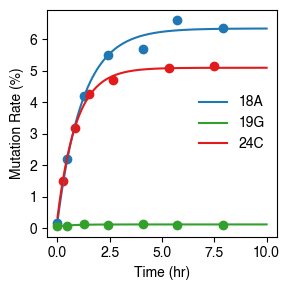

In [7]:
fourU_A = rep_freefit('4U_wt', 25, 18, chosen_rg_id = 80)
fourU_G = rep_freefit('4U_wt', 25, 19, chosen_rg_id = 80)
hiv_unpaired = rep_freefit('hiv_wt', 25, 24, chosen_rg_id = 84)

fig, ax = plt.subplots(figsize = (3, 3))
plot_fit(fourU_A, ax, f'18A', color = sns.color_palette("Paired")[1])
plot_fit(fourU_G, ax, f'19G', color = sns.color_palette("Paired")[3])
plot_fit(hiv_unpaired, ax, f'24C', color = sns.color_palette("Paired")[5])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False)
plt.tight_layout()


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


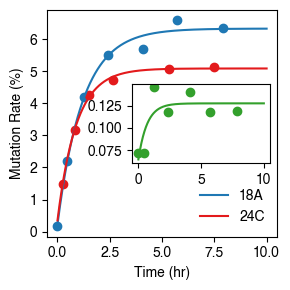

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(3, 3))
plot_fit(fourU_A, ax, '18A', color=sns.color_palette("Paired")[1])
#plot_fit(fourU_G, ax, '19G', color=sns.color_palette("Paired")[3])
plot_fit(hiv_unpaired, ax, '24C', color=sns.color_palette("Paired")[5])

# Main axis labels and legend
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon=False)
plt.tight_layout()

# Create inset axes
axins = inset_axes(ax, width="60%", height="35%", loc='right')  # location can be adjusted

# Plot just fourU_G in the inset
plot_fit(fourU_G, axins, '19G', color=sns.color_palette("Paired")[3])

plt.savefig('combined_timecourse_plot.pdf', bbox_inches='tight')

# Optionally zoom in on a region
#axins.set_xticks([])
#axins.set_yticks([])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 18

┌── Free fitting started for site 18...
│   ├── ✅ Free fit succeeded at site 18, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 80
│   ├── Construct: 4U_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 29

┌── Free fitting started for site 29...
│   ├── ✅ Free fit succeeded at site 29, appended to store_results
└── 🎉 Free fitting complete! Results stored.
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-2.762957037773717) +/- 0.0485, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.40379450918865) +/- 0.126, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-6.1225819220843745) +/- 1.15, bounds=[-inf:inf]>)])
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-5.356140561970059) +/- 0.074, bounds

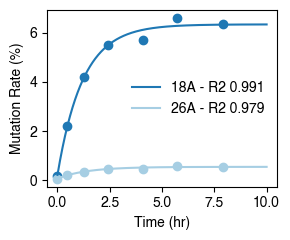

In [9]:
fourU_18 = rep_freefit('4U_wt', 25, 18, chosen_rg_id = 80)
fourU_26 = rep_freefit('4U_wt', 25, 29, chosen_rg_id = 80)

# print params
print(fourU_18.params)
print(fourU_26.params)

fig, ax = plt.subplots(figsize = (3, 2.5))
plot_fit(fourU_18, ax, f'18A - R2 {fourU_18.rsquared:.3f}', color = sns.color_palette("Paired")[1])
plot_fit(fourU_26, ax, f'26A - R2 {fourU_26.rsquared:.3f}', color = sns.color_palette("Paired")[0])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False)
plt.tight_layout()
plt.savefig('./4U_wt_representative_fits.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


┌── Representative reaction group ID: 84
│   ├── Construct: hiv_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 24

┌── Free fitting started for site 24...
│   ├── ✅ Free fit succeeded at site 24, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 84
│   ├── Construct: hiv_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 30

┌── Free fitting started for site 30...
│   ├── ✅ Free fit succeeded at site 30, appended to store_results
└── 🎉 Free fitting complete! Results stored.
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-3.024552980554805) +/- 0.0367, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.103709363826974) +/- 0.0708, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-5.66027723357545) +/- 0.502, bounds=[-inf:inf]>)])
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-5.771404666134922) +/- 0.165, bou

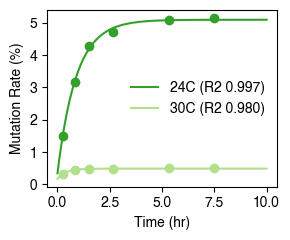

In [10]:
hiv_unpaired = rep_freefit('hiv_wt', 25, 24, chosen_rg_id = 84)
hiv_paired = rep_freefit('hiv_wt', 25, 30, chosen_rg_id = 84)

print(hiv_unpaired.params)
print(hiv_paired.params)

fig, ax = plt.subplots(figsize = (3, 2.5))
plot_fit(hiv_unpaired, ax, f'24C (R2 {hiv_unpaired.rsquared:.3f})', color = sns.color_palette("Paired")[3])
plot_fit(hiv_paired, ax, f'30C (R2 {hiv_paired.rsquared:.3f})', color = sns.color_palette("Paired")[2])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False)
plt.tight_layout()
plt.savefig('./hiv_wt_representative_fits.pdf')
plt.show()

┌── Representative reaction group ID: 99
│   ├── Construct: hiv_es2
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 24
    ⚠️  Reaction group 99 is in the manual QC to drop list, dropping the following reaction times: [27000]

┌── Free fitting started for site 24...
│   ├── ✅ Free fit succeeded at site 24, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 83
│   ├── Construct: hiv_wt
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 24

┌── Free fitting started for site 24...
│   ├── ✅ Free fit succeeded at site 24, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 116
│   ├── Construct: hiv_c30u
│   ├── Temperature: 25
│   ├── Buffer: None
│   ├── Site: 24
    ⚠️  Reaction group 116 is in the manual QC to drop list, dropping the following reaction times: [27000]

┌── Free fitting started for site 24...
│   ├── ✅ Free fit succeeded at site 24, append

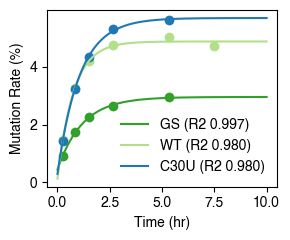

In [11]:
hiv_gs = rep_freefit('hiv_es2', 25, 24)
hiv_wt = rep_freefit('hiv_wt', 25, 24)
hiv_c30u = rep_freefit('hiv_c30u', 25, 24) # light

fig, ax = plt.subplots(figsize = (3, 2.5))
plot_fit(hiv_gs, ax, f'GS (R2 {hiv_unpaired.rsquared:.3f})', color = sns.color_palette("Paired")[3])
plot_fit(hiv_wt, ax, f'WT (R2 {hiv_paired.rsquared:.3f})', color = sns.color_palette("Paired")[2])
plot_fit(hiv_c30u, ax, f'C30U (R2 {hiv_paired.rsquared:.3f})', color = sns.color_palette("Paired")[1])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False)
plt.tight_layout()
#plt.savefig('./hiv_wt_representative_fits.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


┌── Representative reaction group ID: 123
│   ├── Construct: p4p6_wt_nobc
│   ├── Temperature: 23
│   ├── Buffer: 2
│   ├── Site: 152

┌── Free fitting started for site 152...
│   ├── ✅ Free fit succeeded at site 152, appended to store_results
└── 🎉 Free fitting complete! Results stored.
┌── Representative reaction group ID: 124
│   ├── Construct: p4p6_wt_nobc
│   ├── Temperature: 23
│   ├── Buffer: 3
│   ├── Site: 152

┌── Free fitting started for site 152...
│   ├── ✅ Free fit succeeded at site 152, appended to store_results
└── 🎉 Free fitting complete! Results stored.
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-3.931924471065187) +/- 0.028, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.03697176046929) +/- 0.0707, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-8.463599289718513) +/- 2.31, bounds=[-inf:inf]>)])
Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-4.859506922362584) +/

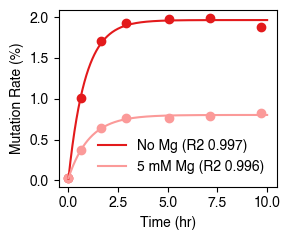

In [12]:
p4p6_nomg = rep_freefit('p4p6_wt_nobc', 23, 152, 2, chosen_rg_id = 123)
p4p6_mg = rep_freefit('p4p6_wt_nobc', 23, 152, 3, chosen_rg_id = 124)

print(p4p6_nomg.params)
print(p4p6_mg.params)

fig, ax = plt.subplots(figsize = (3, 2.5))
plot_fit(p4p6_nomg, ax, f'No Mg (R2 {p4p6_nomg.rsquared:.3f})', color = sns.color_palette("Paired")[5])
plot_fit(p4p6_mg, ax, f'5 mM Mg (R2 {p4p6_mg.rsquared:.3f})', color = sns.color_palette("Paired")[4])
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Mutation Rate (%)')
ax.legend(frameon = False)

plt.tight_layout()
plt.savefig('./p4p6_wt_representative_fits.pdf')
plt.show()

In [ ]:
fourU 18A -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-2.762957037773717) +/- 0.0485, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.40379450918865) +/- 0.126, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-6.1225819220843745) +/- 1.15, bounds=[-inf:inf]>)])
fourU 26A -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-5.356140561970059) +/- 0.074, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.553708545038003) +/- 0.202, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-7.19646664771671) +/- 0.399, bounds=[-inf:inf]>)])
hiv 24C -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-3.024552980554805) +/- 0.0367, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.103709363826974) +/- 0.0708, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-5.66027723357545) +/- 0.502, bounds=[-inf:inf]>)])
hiv 30C -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-5.771404666134922) +/- 0.165, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-7.271122815024167) +/- 0.237, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-6.33136688688796) +/- 0.298, bounds=[-inf:inf]>)])
p4p6 152A No Mg -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-3.931924471065187) +/- 0.028, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.03697176046929) +/- 0.0707, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-8.463599289718513) +/- 2.31, bounds=[-inf:inf]>)])
p4p6 152A 5 mM Mg -> Parameters([('log_kappa', <Parameter 'log_kappa', value=np.float64(-4.859506922362584) +/- 0.0299, bounds=[-inf:inf]>), ('log_kdeg', <Parameter 'log_kdeg', value=np.float64(-8.254786841223186) +/- 0.075, bounds=[-inf:inf]>), ('log_fmod_0', <Parameter 'log_fmod_0', value=np.float64(-8.157688832894667) +/- 0.721, bounds=[-inf:inf]>)])
fourU
color = sns.color_palette("Paired")[1]
color = sns.color_palette("Paired")[0]
hiv
color = sns.color_palette("Paired")[3]
color = sns.color_palette("Paired")[2]
p4p6
color = sns.color_palette("Paired")[5]
color = sns.color_palette("Paired")[4]

SyntaxError: invalid decimal literal (392113839.py, line 1)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


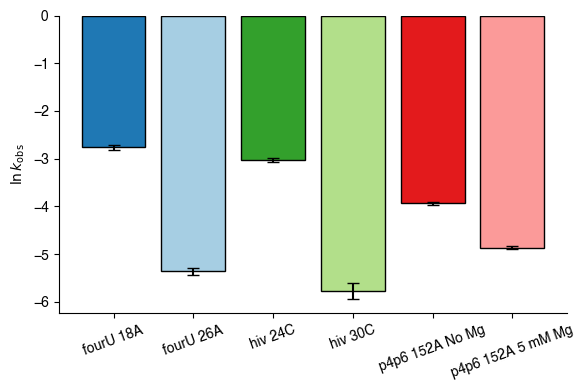

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# raw fit outputs -----------------------------------------------------------
records = [
    ("fourU 18A",  "log_kappa",   -2.762957037773717, 0.0485),
    ("fourU 18A",  "log_kdeg",    -8.40379450918865,  0.126),
    ("fourU 18A",  "log_fmod_0",  -6.1225819220843745, 1.15),

    ("fourU 26A",  "log_kappa",   -5.356140561970059, 0.074),
    ("fourU 26A",  "log_kdeg",    -8.553708545038003, 0.202),
    ("fourU 26A",  "log_fmod_0",  -7.19646664771671,  0.399),

    ("hiv 24C",    "log_kappa",   -3.024552980554805, 0.0367),
    ("hiv 24C",    "log_kdeg",    -8.103709363826974, 0.0708),
    ("hiv 24C",    "log_fmod_0",  -5.66027723357545,  0.502),

    ("hiv 30C",    "log_kappa",   -5.771404666134922, 0.165),
    ("hiv 30C",    "log_kdeg",    -7.271122815024167, 0.237),
    ("hiv 30C",    "log_fmod_0",  -6.33136688688796,  0.298),

    ("p4p6 152A No Mg",    "log_kappa",   -3.931924471065187, 0.028),
    ("p4p6 152A No Mg",    "log_kdeg",    -8.03697176046929,  0.0707),
    ("p4p6 152A No Mg",    "log_fmod_0",  -8.463599289718513, 2.31),

    ("p4p6 152A 5 mM Mg",  "log_kappa",   -4.859506922362584, 0.0299),
    ("p4p6 152A 5 mM Mg",  "log_kdeg",    -8.254786841223186, 0.075),
    ("p4p6 152A 5 mM Mg",  "log_fmod_0",  -8.157688832894667, 0.721),
]

df = pd.DataFrame(records, columns=["condition", "parameter", "value", "stderr"])

# color assignments --------------------------------------------------------
paired = sns.color_palette("Paired")
condition_colors = {
    "fourU 18A": paired[1],
    "fourU 26A": paired[0],
    "hiv 24C": paired[3],
    "hiv 30C": paired[2],
    "p4p6 152A No Mg": paired[5],
    "p4p6 152A 5 mM Mg": paired[4],
}
df["color"] = df["condition"].map(condition_colors)

# choose which parameter to visualize --------------------------------------
param_to_plot = "log_kappa"  # change to "log_kdeg" or "log_fmod_0" as needed
plot_df = df[df["parameter"] == param_to_plot].copy()

# plot ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))
sns.despine(ax=ax)

bars = ax.bar(
    plot_df["condition"],
    plot_df["value"],
    yerr=plot_df["stderr"],
    color=plot_df["color"],
    edgecolor="black",
    capsize=4,
)

ax.set_ylabel(r"$\ln{k_{\text{obs}}}$")
ax.set_xlabel("")
ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.savefig('kobs_barplot.pdf')
plt.show()
